## Process Fielddata

**Code authored by:** Andrew Johnson, Simon Zwieback, Franz Meyer, Jie Chen</br>
2024

This notebook takes the field observations and combines them into a single surface displacement for each field site, so that they can be properly compared to InSAR products.

NOTE: The field data will be added to the Cal/Val database. Before then, the 2023 data is provided by a set of small .csv files included here. 

### Prepare notebook environment

First we import functions, set directories, and the site metadata.

In [3]:

from pathlib import Path
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from datetime import datetime


In [4]:
site='NorthSlopeEastD102'
year=2023

if 'base_dir' not in locals():
    base_dir = Path.cwd()
if 'work_dir' not in locals():
    work_dir = base_dir/'work'/'permafrost_ouputs'/site/str(year)
if 'field_dir' not in locals():
    field_dir = work_dir/'fielddata'

print("Field directory:", field_dir)
work_dir.mkdir(parents=True, exist_ok=True)
field_dir.mkdir(parents=True,exist_ok=True)

Field directory: /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2023/fielddata


In [5]:
fieldsites = ['HV','HVE','IC','SM']
fieldsitenames = ['Happy Valley','Happy Valley East','Ice Cut','Slope Mountain']
fieldsitelocs = [[69.15478,-148.84382],[69.15531,-148.83792],[69.04113,-148.83162],[68.43289,-148.94216]]

In [6]:
# option to unzip field data directly [True/False]
# Set to False if importing field data from Cal/Val data base instead (not implemented yet).
Unzip_field_data = True

os.system(f'unzip {str(base_dir)}/field_data_2023.zip -d {field_dir}/')

Archive:  /home/jovyan/forks/ATBD/methods/permafrost/field_data_2023.zip
  inflating: /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2023/fielddata/SM_displacement_level.csv  
  inflating: /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2023/fielddata/SM_displacement_gnss.csv  
  inflating: /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2023/fielddata/IC_displacement_level.csv  
  inflating: /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2023/fielddata/IC_displacement_gnss.csv  
  inflating: /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2023/fielddata/HVE_displacement_level.csv  
  inflating: /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2023/fielddata/HVE_displacement_gnss.csv  
  inflating: /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/Nor

0

### Open Field Data

Each field site covers a 100 by 100 m square of the tundra. We use a fixed benchmark, usually a PVC pipe frozen into a several-meter deep borehole as a non-deforming point on the terrain. There are 3 transects, each of 100 m in length and spaced 50 m apart in order to cover the entire site. Ever 2 meters along the transect we marked a point by a nail in the ground. In the field we use GNSS and leveling (surveying) to measure the elevation of each of these points along the transects relative to the fixed benchmark. These measurements are made at the beginning and end of the summer when the surface is snow-free.

The first step is to open the field data from the .csv files.

In these files, the 'pointname' column has the format Txxyy: xx is the transact number, yy is the point number in each transact. yy *  2 will give you meters along transect, going from South to North and/or West to East (transects are not perfectly aligned South-North).

Data quality flags:</br>
0: High quality;</br>
1: Low quality with deviation to the averaged value larger than 15 cm;</br>
2: Unreasonable data;</br>
3: No data

In [7]:
def open_fielddata(site,field_dir):
    """Opens the leveling and GNSS data for the given site."""
    ldata = pd.read_csv(field_dir/f'{site}_displacement_level.csv')
    ldata['transect'] = [i[0:3] for i in ldata['point_name']]
    ldata['trans_dist'] = [int(i[3:])*2 for i in ldata['point_name']]
    ldata['mask'] = ldata['flag'][:]==0
    
    gdata = pd.read_csv(field_dir/f'{site}_displacement_gnss.csv')
    gdata['transect'] = [i[0:3] for i in gdata['point_name'][:]]
    gdata['trans_dist'] = [int(i[3:])*2 for i in gdata['point_name']]
    gdata['mask'] = gdata['flag'][:]==0
    return ldata,gdata


In [8]:
#get dates from data
date1list,date2list = [],[]

for site in fieldsites:
    ldata,gdata = open_fielddata(site,field_dir)
    #get dates using leveling date (if possible)
    date1,date2 = ldata['date1'][0],ldata['date2'][0]
    if np.isnan(date1):
        date1 = gdata['date1'][0]
        if np.isnan(date1):
            date1 = f'{year}0525'
    if np.isnan(date2):
        date2 = gdata['date2'][0]
        if np.isnan(date2):
            date2 = f'{year}0820'
    date1list.append(str(date1))
    date2list.append(str(date2))

Regarding 2023, the transects for the site Happy Valley East were created in August 2023, and therefore subsidence measurements do not exist for that summer. At Slope Mountain, the GNSS measurements were not collected in June 2023, and therefore summer displacements only come from the surveying.

Now we can plot the field measurements.

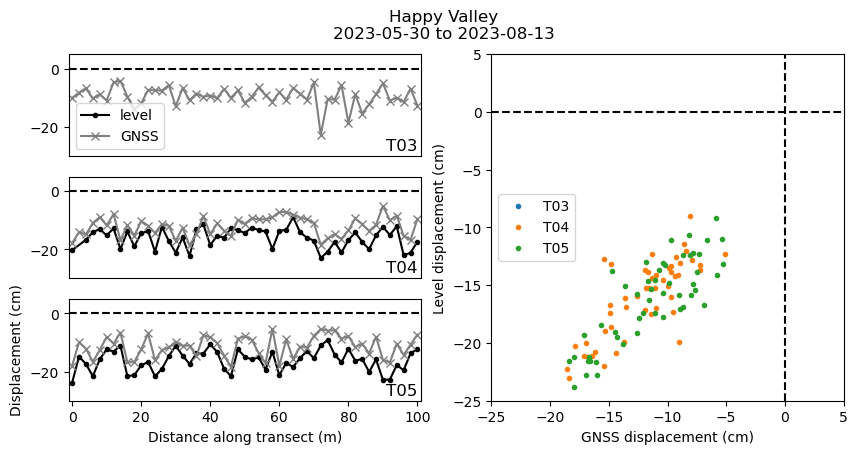

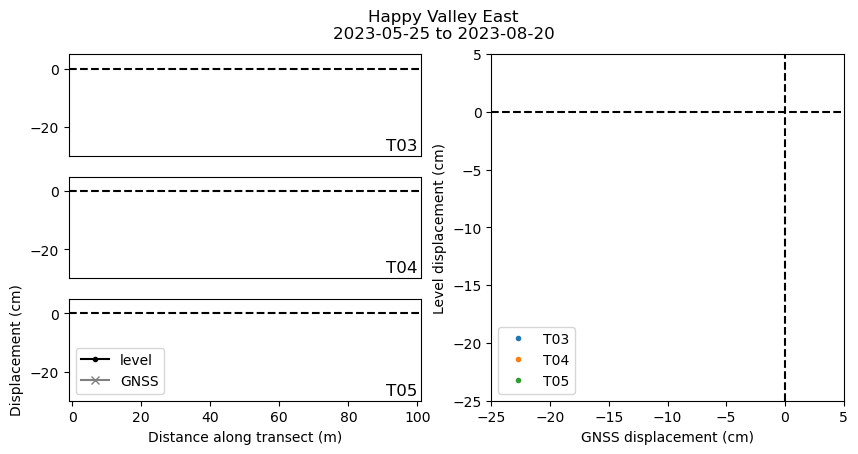

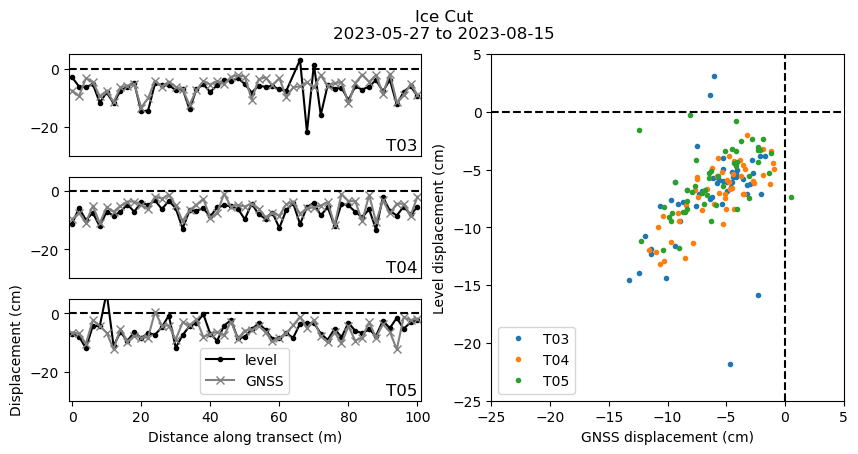

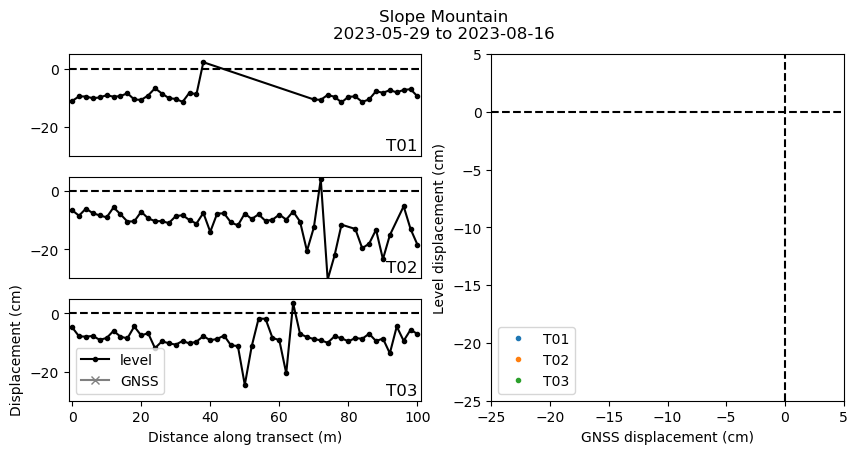

In [9]:
#plot the field data displacement results
for k,site in enumerate(fieldsites):

    ldata,gdata = open_fielddata(site,field_dir)
    translist = np.unique(ldata['transect'][:])
    
    clist = ['C00','C01','C02']

    fig = plt.figure(figsize=(10,4.5))
    ax = fig.add_subplot(1,2,2)
    d1str = datetime.strptime(date1list[k],'%Y%m%d').strftime('%Y-%m-%d')
    d2str = datetime.strptime(date2list[k],'%Y%m%d').strftime('%Y-%m-%d')
    fig.suptitle(f'{fieldsitenames[k]}\n{d1str} to {d2str}')
    for i,t in enumerate(translist):
        lt = ldata.iloc[np.array(ldata['transect'][:])==t]
        gt = gdata.iloc[np.array(gdata['transect'][:])==t]
        
        axt = fig.add_subplot(3,2,1+i*2)    
        axt.plot(lt.iloc[np.array(lt['mask'])]['trans_dist'],
                 lt.iloc[np.array(lt['mask'])]['height_diff']*100,'.-',color='black',label='level')
        axt.plot(gt.iloc[np.array(gt['mask'])]['trans_dist'],
                 gt.iloc[np.array(gt['mask'])]['height_diff']*100,'x-',color='gray',label='GNSS')

        axt.set_ylim(-30,5)
        axt.set_xlim(-1,101)
        axt.axhline(0,linestyle='--',color='k')
        axt.text(91,-28,t,fontsize=12)
        
        if i<2:
            axt.set_xticks([])
        if i==2:
            if k!=0:
                axt.legend()
            axt.set_xlabel('Distance along transect (m)')
            axt.set_ylabel('Displacement (cm)')
        if k==0:
            if i==0:
                axt.legend(loc=3)
        
                 # ax2.plot(np.arange(np.sum(gt['mask']))*2,gt.iloc[np.array(gt['mask'])]['height_diff'],'.-')
    
        tmask = lt['mask'] & gt['mask']
        ltvec,gtvec = lt[tmask]['height_diff'][:],gt[tmask]['height_diff'][:]
        ax.plot(gtvec*100,ltvec*100,'.',label=t)

    ax.axhline(0,linestyle='--',color='k')
    ax.axvline(0,linestyle='--',color='k')
    ax.legend()
    ax.set_xlim([-25,5])
    ax.set_ylim([-25,5])
    ax.set_xlabel('GNSS displacement (cm)')
    ax.set_ylabel('Level displacement (cm)')

    lmask,gmask = ldata['flag'][:]==0,gdata['flag'][:]==0
    mask = (lmask) & (gmask)
    ldatavec,gdatavec = ldata['height_diff'][:],gdata['height_diff'][:]
    lmean,lstd = np.mean(ldatavec[lmask]),np.std(ldatavec[lmask])
    gmean,gstd = np.mean(gdatavec[gmask]),np.std(gdatavec[gmask])

### Save mean values

We take the mean value across each 100 m site to make it comprable to the InSAR results. The mean values and standard deviations are saved into ```field_results.csv```.

In [10]:
#initialize dataframe
fielddisp = pd.DataFrame(columns = ['name','date1','date2','latitude','longitude','rel_change','stdev'])
for i,site in enumerate(fieldsites):
    # print(site)
    lat,lon = fieldsitelocs[i]
    ldata,gdata = open_fielddata(site,field_dir)

    lmask,gmask = ldata['flag'][:]==0,gdata['flag'][:]==0
    ldisp,lstd = np.mean(ldata[lmask]['height_diff']),np.std(ldata[lmask]['height_diff'])
    gdisp,gstd = np.mean(gdata[gmask]['height_diff']),np.std(gdata[gmask]['height_diff'])
    tdisp = np.nanmean([ldisp,gdisp])

    #get standard deviation between measurement types, propogate errors
    #conditional used to avoid dividing by zero if there is no data
    stdvec = np.array([lstd,gstd])
    ntot = np.sum(~np.isnan(stdvec))
    if ntot>0:
        tstd = 1/ntot*np.sqrt(np.nansum(stdvec**2))
    else:
        tstd = np.nan

    print(f'{site}')
    print(f'Mean from leveling: {ldisp*100:.1f} +/- {lstd*100:.1f} cm')
    print(f'Mean from GNSS:     {gdisp*100:.1f} +/- {gstd*100:.1f} cm')
    print(f'Overall mean:       {tdisp*100:.1f} +/- {tstd*100:.1f} cm\n')

    
    sitedata = [site,date1list[i],date2list[i],lat,lon,tdisp,tstd]
    fielddisp.loc[i]=sitedata
print('Displaying dataframe:')
print(fielddisp)

svfile = field_dir/'field_results.csv'
print(f'\n Saving data to {str(svfile)}')
fielddisp.to_csv(svfile)

HV
Mean from leveling: -16.2 +/- 3.5 cm
Mean from GNSS:     -11.0 +/- 3.6 cm
Overall mean:       -13.6 +/- 2.5 cm

HVE
Mean from leveling: nan +/- nan cm
Mean from GNSS:     nan +/- nan cm
Overall mean:       nan +/- nan cm

IC
Mean from leveling: -6.7 +/- 3.4 cm
Mean from GNSS:     -6.0 +/- 2.9 cm
Overall mean:       -6.3 +/- 2.3 cm

SM
Mean from leveling: -9.6 +/- 4.4 cm
Mean from GNSS:     nan +/- nan cm
Overall mean:       -9.6 +/- 4.4 cm

Displaying dataframe:
  name     date1     date2  latitude  longitude  rel_change     stdev
0   HV  20230530  20230813  69.15478 -148.84382   -0.136049  0.025139
1  HVE  20230525  20230820  69.15531 -148.83792         NaN       NaN
2   IC  20230527  20230815  69.04113 -148.83162   -0.063390  0.022596
3   SM  20230529  20230816  68.43289 -148.94216   -0.096067  0.043627

 Saving data to /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2023/fielddata/field_results.csv


/tmp/ipykernel_511/2437221705.py:11: RuntimeWarning: Mean of empty slice
  tdisp = np.nanmean([ldisp,gdisp])
